In [16]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from DCGAN import *

font = {'family': 'serif', 'size': 12}
plt.rc('font', **font)

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Root directory for dataset
dataroot = "../data_meta_T/data_5000_h/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 4
# Size of feature maps in generator
ngf = 48

# Size of feature maps in discriminator
ndf = 48

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers

lr = 0.0005

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=os.path.normpath(dataroot),
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(nc),
                            #    transforms.RandomHorizontalFlip(p=0.5),
                            #    transforms.RandomRotation(degrees=15),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                               
                           ]))
# Create the dataloader

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

Random Seed:  999


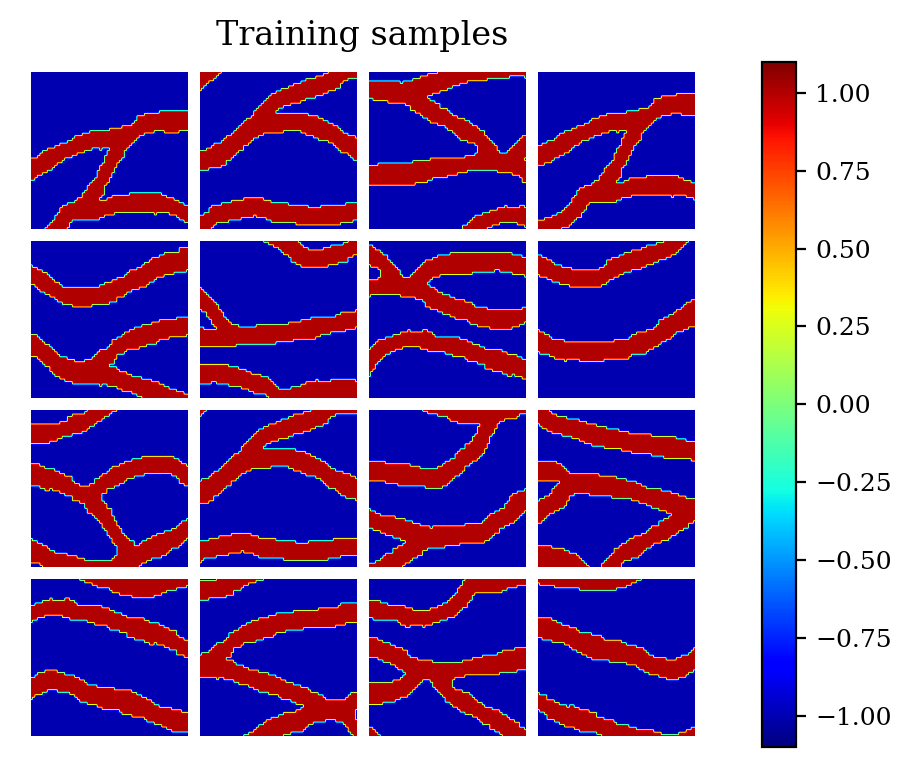

In [2]:
%config InlineBackend.figure_format = 'retina'
real_batch = next(iter(dataloader))
fig = plt.figure(figsize=(6, 4))
plt.axis("off")
plt.title("Training samples",fontsize=12)
temp = real_batch[0].to(device)[:16]
temp2 = np.transpose(vutils.make_grid(temp,nrow =4, padding=4, normalize = False).cpu(),(1,2,0))
temp2[temp2 == 0] = np.nan

plt.imshow(torch.mean(temp2,axis=2),cmap='jet',vmax=1.1,vmin=-1.1)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=9)
plt.tight_layout()

In [17]:
real_batch[0].shape
torch.manual_seed(123)
ratios = []
for i in range (50):
        real_batch = next(iter(dataloader))[0]
        real_batch[real_batch>0] = 1
        real_batch[real_batch<0] = 0
        real_batch = real_batch.squeeze()
        for image in real_batch:
                image_array = np.array(image)

                # Count the number of 1s and 0s in the image
                num_ones = np.sum(image_array)
                num_zeros = image_array.size

                # Calculate the ratio of 1s to 0s
                if num_zeros != 0:
                        ratio = num_ones / num_zeros
                        ratios.append(ratio)
                else:
                        ratios.append(np.inf)  # Handle case where there are no zeros
                
    # Print or analyze the calculated ratios
for idx, ratio in enumerate(ratios):
    print(f"Image {idx+1}: Ratio of 1s to 0s = {ratio:.2f}")

np.save('ratios_train.npy', ratios)
        

Image 1: Ratio of 1s to 0s = 0.23
Image 2: Ratio of 1s to 0s = 0.32
Image 3: Ratio of 1s to 0s = 0.29
Image 4: Ratio of 1s to 0s = 0.38
Image 5: Ratio of 1s to 0s = 0.30
Image 6: Ratio of 1s to 0s = 0.32
Image 7: Ratio of 1s to 0s = 0.31
Image 8: Ratio of 1s to 0s = 0.28
Image 9: Ratio of 1s to 0s = 0.24
Image 10: Ratio of 1s to 0s = 0.25
Image 11: Ratio of 1s to 0s = 0.35
Image 12: Ratio of 1s to 0s = 0.26
Image 13: Ratio of 1s to 0s = 0.41
Image 14: Ratio of 1s to 0s = 0.32
Image 15: Ratio of 1s to 0s = 0.28
Image 16: Ratio of 1s to 0s = 0.26
Image 17: Ratio of 1s to 0s = 0.35
Image 18: Ratio of 1s to 0s = 0.26
Image 19: Ratio of 1s to 0s = 0.33
Image 20: Ratio of 1s to 0s = 0.34
Image 21: Ratio of 1s to 0s = 0.32
Image 22: Ratio of 1s to 0s = 0.41
Image 23: Ratio of 1s to 0s = 0.20
Image 24: Ratio of 1s to 0s = 0.27
Image 25: Ratio of 1s to 0s = 0.32
Image 26: Ratio of 1s to 0s = 0.28
Image 27: Ratio of 1s to 0s = 0.15
Image 28: Ratio of 1s to 0s = 0.27
Image 29: Ratio of 1s to 0s =

In [14]:
num_ones

1020.0

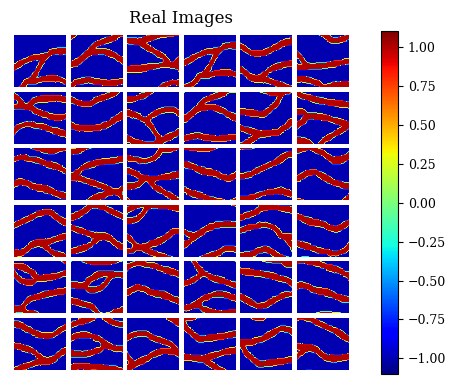

In [2]:
real_batch = next(iter(dataloader))
fig = plt.figure(figsize=(6, 4))
plt.axis("off")
plt.title("Real Images",fontsize=12)
temp = real_batch[0].to(device)[:36]
temp2 = np.transpose(vutils.make_grid(temp,nrow =6, padding=4, normalize = False).cpu(),(1,2,0))
temp2[temp2 == 0] = np.nan

plt.imshow(torch.mean(temp2,axis=2),cmap='jet',vmax=1.1,vmin=-1.1)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=9)
plt.tight_layout()